# Importing necessary libraries

In [17]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import sys
from PIL import Image
import cv2
import csv
import helper
%matplotlib inline

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models, utils
from torchvision.utils import make_grid
import imageio
from sklearn.metrics import confusion_matrix
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

In [18]:
def show_images(dataloader): 
    for images, labels in dataloader:
        fig, ax = plt.subplots(figsize=(16,16))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=5).permute(1, 2, 0))
        break

def accuracy(output, target):
    output = torch.exp(output)
    top_p,top_class = output.topk(1,dim = 1)
    equals = top_class == target.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [19]:
train_on_gpu = torch.cuda.is_available()
train_on_gpu

False

# Setting necessary paths

In [20]:
path = '/home/sysadm/Desktop/3ml/chest_xray'
train_dir = path + '/train'
test_dir = path + '/test'

# Creating dataframe with data stats

In [21]:
n_train = []
n_test = []
classes = ['PNEUMONIA', 'NORMAL']
for c in classes:
    train_images = os.listdir(train_dir + '/' + c)
    n_train.append(len(train_images))
    test_images = os.listdir(test_dir + '/' + c)
    n_test.append(len(test_images))
  

In [22]:
print(n_train)
print(n_test)

[3884, 1349]
[390, 235]


In [23]:
data = pd.DataFrame({'Classes' : classes,
                      'Train' : n_train,
                      'Test' : n_test})
print(data)

     Classes  Train  Test
0  PNEUMONIA   3884   390
1     NORMAL   1349   235



# Visualising data stats

Text(0.5, 1.0, 'Training data')

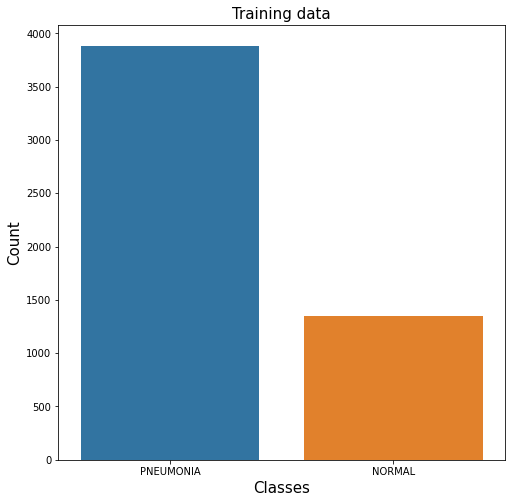

In [24]:
plt.figure(figsize=(8,8))
sns.barplot(data=data, x='Classes', y='Train')
plt.xlabel('Classes',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.title('Training data',fontsize=15)

Text(0.5, 1.0, 'Test data')

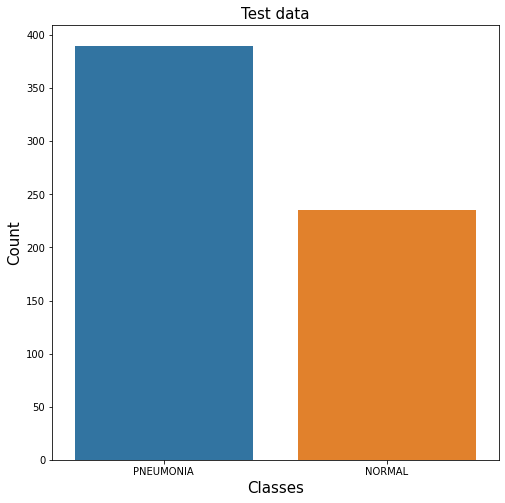

In [25]:
plt.figure(figsize=(8,8))
sns.barplot(data=data, x='Classes', y='Test')
plt.xlabel('Classes',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.title('Test data',fontsize=15)

# Creating dataframe from images and labels


In [28]:
# train set

ptrain = []
ctrain = []
for folder_name in classes:
    for files in os.listdir(train_dir + '/' + folder_name):
        if files.split(".")[-1].lower() in {"jpeg", "jpg", "png"}:
            path = train_dir + '/' + folder_name + '/' + files
            clss = folder_name
            ptrain.append(path)
            ctrain.append(clss)


# test set

ptest = []
ctest = []
for folder_name in classes:
    for files in os.listdir(test_dir + '/' + folder_name):
        if files.split(".")[-1].lower() in {"jpeg", "jpg", "png"}:
            path = test_dir + '/' + folder_name + '/' + files
            clss = folder_name
            ptest.append(path)
            ctest.append(clss)

In [29]:
train_df = pd.DataFrame({'Path':ptrain,'Class':ctrain})
test_df = pd.DataFrame({'Path':ptest,'Class':ctest})
train_df.head(10)


Path      Class
0  /home/sysadm/Desktop/3ml/chest_xray/train/PNEU...  PNEUMONIA
1  /home/sysadm/Desktop/3ml/chest_xray/train/PNEU...  PNEUMONIA
2  /home/sysadm/Desktop/3ml/chest_xray/train/PNEU...  PNEUMONIA
3  /home/sysadm/Desktop/3ml/chest_xray/train/PNEU...  PNEUMONIA
4  /home/sysadm/Desktop/3ml/chest_xray/train/PNEU...  PNEUMONIA
5  /home/sysadm/Desktop/3ml/chest_xray/train/PNEU...  PNEUMONIA
6  /home/sysadm/Desktop/3ml/chest_xray/train/PNEU...  PNEUMONIA
7  /home/sysadm/Desktop/3ml/chest_xray/train/PNEU...  PNEUMONIA
8  /home/sysadm/Desktop/3ml/chest_xray/train/PNEU...  PNEUMONIA
9  /home/sysadm/Desktop/3ml/chest_xray/train/PNEU...  PNEUMONIA

# Data to csv

In [30]:
train_df.to_csv('train_data.csv',index=False)
test_df.to_csv('test_data.csv',index=False)

# Defining transformations for data augumentation

In [31]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize((256,256)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                       ]) 

test_transforms = transforms.Compose([transforms.Resize((256,256)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                      ])

# Creating Custom Dataloader

In [32]:
class PneumoniaDataset():
    def __init__(self,df,labels,transform=True):
        self.df = df
        self.labels=list(df.iloc[:,1])
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        row = self.df.loc[idx]
        img_file, img_class = row['Path'], row['Class']
        img = Image.open(img_file).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img,img_class

In [33]:
class_dict = {'NORMAL':0, 'PNEUMONIA':1}
train_data = PneumoniaDataset(train_df,class_dict,transform = train_transforms)
test_data = PneumoniaDataset(test_df,class_dict,transform = test_transforms)

# verifying the dataloader

print(len(train_data))
next(iter(train_data))

5232


(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]),
 'PNEUMONIA')

In [34]:
print(len(test_data))
next(iter(test_data))

624


(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]),
 'PNEUMONIA')

# Splitting training data into training and validation sets

In [35]:
# training indices to be used for validation

num_train = len(train_data); print(num_train)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(0.2 * num_train)); print(split)
train_idx, valid_idx = indices[split:], indices[:split] 

5232
1046


In [36]:
# defining samplers for obtaining training and validation batches

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [37]:
# loading the data 

train_loader = torch.utils.data.DataLoader(train_data, batch_size = 30, sampler = train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = 30, sampler = valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 30, shuffle = True)
next(iter(train_loader))

[tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]],
 
          [[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]],
 
          [[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         [[[-1., -1., -1.,  ..., -1., -1., -1.],
         

# Visualising the data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


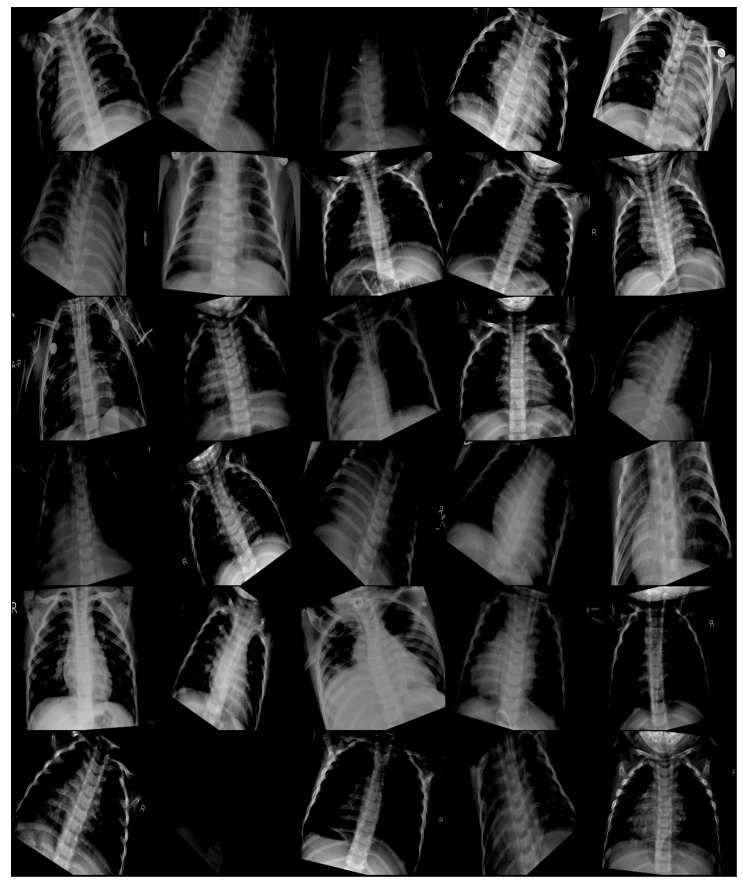

In [38]:
show_images(train_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


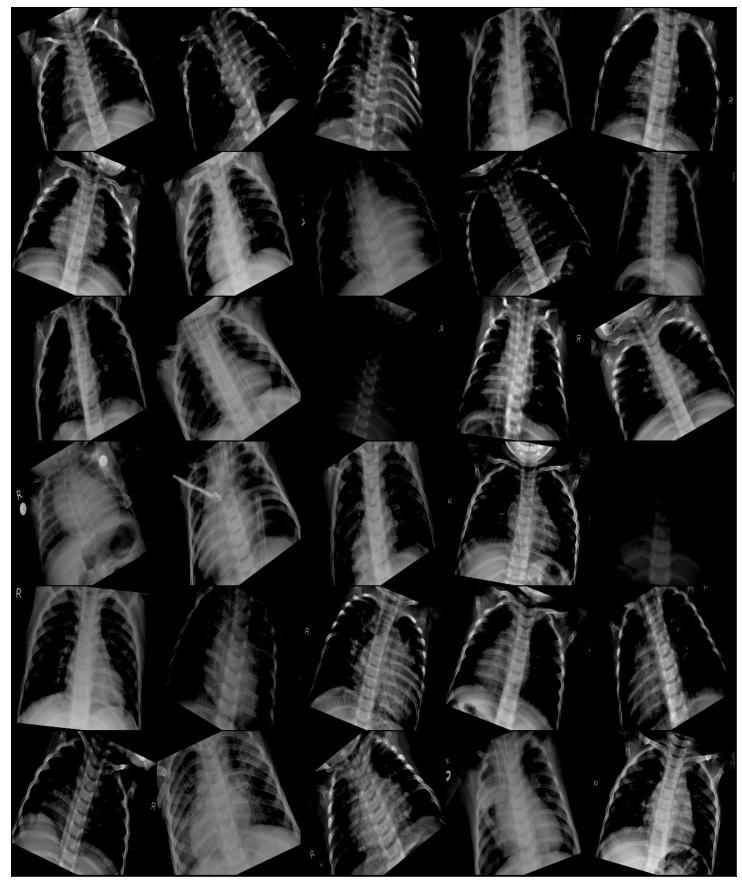

In [39]:
show_images(valid_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


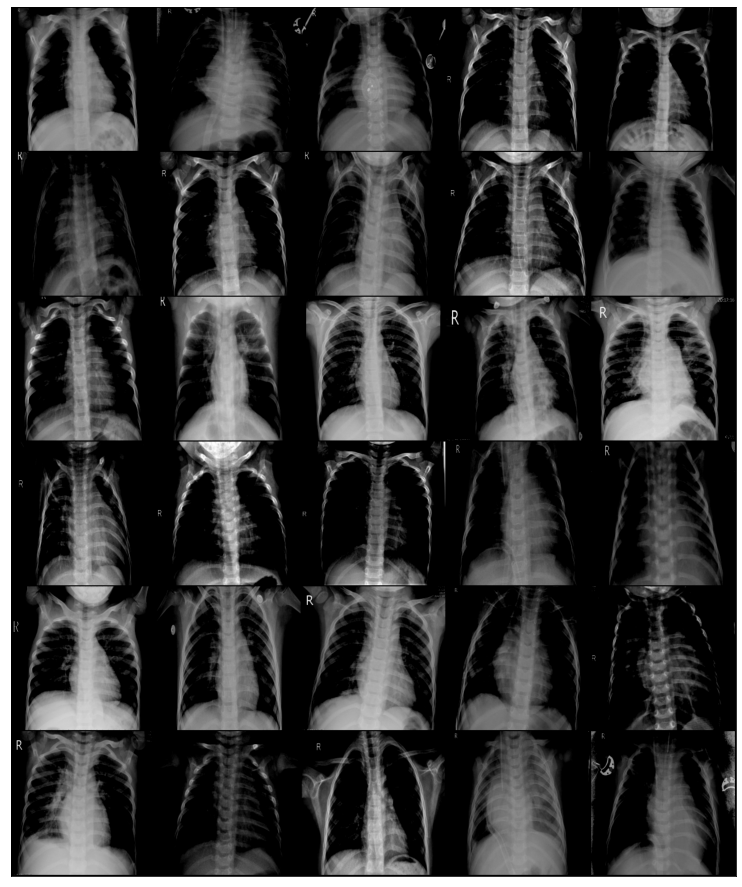

In [40]:
show_images(test_loader)

# Building the model

In [41]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 3, padding = 1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
        self.conv4 = nn.Conv2d(64, 128, 3, padding = 1)
        self.conv5 = nn.Conv2d(128, 256, 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)
        self.bn5 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 8 * 8, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 2)
        self.dropout = nn.Dropout(0.6)

    def forward(self, x):
        
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        
        
        x = x.view(-1, 256 * 8 * 8)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

We have trained this model twice - with 2 different optimisers:


*   Adam
*   SGD with Nesterov accelaration

These are known to produce the best results in image classification problems. The training given below has been done on Adam. To use SGD with Nesterov accelaration instead, use the commented out optimizer instead of the one used below.









In [42]:
# specifying the loss function (categorical cross-entropy)

model = ConvNet()
criterion = nn.CrossEntropyLoss()

# specifying optimizer

optimizer = optim.Adam(model.parameters(), lr = 0.008, weight_decay = 0.02)
# optimizer = optim.SGD(model.parameters(), lr = 0.008,momentum = 0.9, nesterov = True)

# specifying scheduler

scheduler = optim.lr_scheduler.ExponentialLR(optimizer,gamma = 0.2)

if train_on_gpu:
    model.cuda()

print(model)

ConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=1024, bias=True)
  (fc2)

In [46]:
pwd

'/home/sysadm/Desktop/3ml/notebook'


# Training and validating the model


In [ ]:
# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss
train_losses, valid_losses = [], []
train_acc, valid_acc = [], []
for epoch in range(1, n_epochs+1):

    # keeping track of loss and accuracy
    train_loss = 0.0
    valid_loss = 0.0
    train_accuracy = 0.0
    valid_accuracy = 0.0

    ######################
    # training the model #
    ######################
    model.train()
    for data, target in train_loader:
        # moving tensors to GPU if CUDA is available
        data = torch.Tensor(data)
        target = tuple([0 if i=='NORMAL' else 1 for i in list(target)])
        target = torch.Tensor(np.array(target))
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clearing the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        target = target.long()
        # calculating the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # performing a single optimization step (parameter update)
        optimizer.step()
        # updating training loss
        train_loss += loss.item()*data.size(0)
        # updating training accuracy
        train_accuracy += accuracy(output,target)
        
    scheduler.step() # decay LR

    ########################  
    # validating the model #
    ########################
    model.eval()
    for data, target in valid_loader:
        # moving tensors to GPU if CUDA is available
        data = torch.Tensor(data)
        target = tuple([0 if i=='NORMAL' else 1 for i in list(target)])
        target = torch.Tensor(np.array(target))
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        target = target.long()
        # calculating the batch loss
        loss = criterion(output, target)
        # updating average validation loss 
        valid_loss += loss.item()*data.size(0)
        # updating validation accuracy
        valid_accuracy += accuracy(output,target)
    
    # calculating average losses
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)

    # calculating average accuracy
    train_accuracy = train_accuracy/len(train_loader)
    valid_accuracy = valid_accuracy/len(valid_loader)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_acc.append(train_accuracy)
    valid_acc.append(valid_accuracy)
      
    # printing training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \n\t\tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        epoch, train_loss, valid_loss, train_accuracy, valid_accuracy))
    
    # saving model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), './../models/model_pneumonia.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 9.913943 	Validation Loss: 7.245097 
		Training Accuracy: 0.865536 	Validation Accuracy: 0.914945
Validation loss decreased (inf --> 7.245097).  Saving model ...
Epoch: 2 	Training Loss: 6.746061 	Validation Loss: 5.372626 
		Training Accuracy: 0.912709 	Validation Accuracy: 0.930330
Validation loss decreased (7.245097 --> 5.372626).  Saving model ...
Epoch: 3 	Training Loss: 5.242681 	Validation Loss: 4.525079 
		Training Accuracy: 0.935953 	Validation Accuracy: 0.943663
Validation loss decreased (5.372626 --> 4.525079).  Saving model ...
Epoch: 4 	Training Loss: 4.549212 	Validation Loss: 3.961091 
		Training Accuracy: 0.944048 	Validation Accuracy: 0.956850
Validation loss decreased (4.525079 --> 3.961091).  Saving model ...
Epoch: 5 	Training Loss: 4.544940 	Validation Loss: 4.059045 
		Training Accuracy: 0.943393 	Validation Accuracy: 0.952381
Epoch: 6 	Training Loss: 4.442231 	Validation Loss: 4.066547 
		Training Accuracy: 0.950239 	Validation Accuracy: 

# Plotting training/validation losses

In [ ]:

plt.figure(figsize=(10,8))
plt.plot(train_losses,'--',linewidth = 2.5, label='Training loss')
plt.plot(valid_losses,'--', linewidth = 2.5, label='Validation loss')
plt.xlabel('Epochs',fontsize = 20)
plt.ylim(2.5,20)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

# Plotting training/validation accuracy

(array([0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 7 Text major ticklabel objects>)

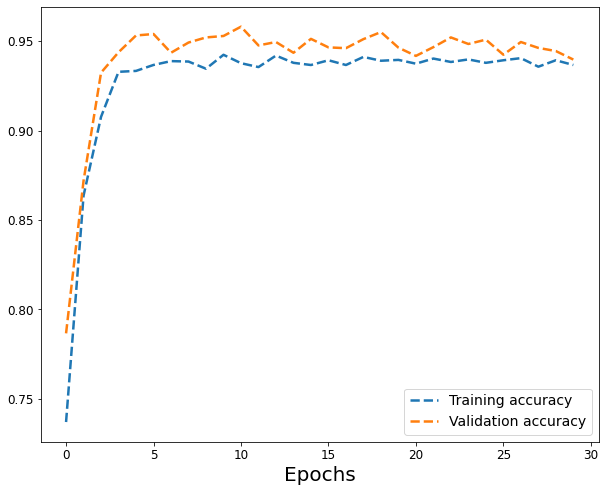

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(train_acc,'--', linewidth = 2.5, label='Training accuracy')
plt.plot(valid_acc,'--', linewidth = 2.5, label='Validation accuracy')
plt.xlabel('Epochs', fontsize = 20)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

# Loading model with lowest validation loss

In [ ]:
model.load_state_dict(torch.load('model_pneumonia.pt'))

<All keys matched successfully>

# Testing the model

In [ ]:
# tracking test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
# iterating over test data
for data, target in test_loader:
    # moving tensors to GPU if CUDA is available
    data = torch.Tensor(data)
    target = tuple([0 if i=='NORMAL' else 1 for i in list(target)])
    target = torch.Tensor(np.array(target))
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: computing predicted outputs by passing inputs to the model
    output = model(data)
    target = target.long()
    # calculating the batch loss
    loss = criterion(output, target)
    # updating test loss 
    test_loss += loss.item()*data.size(0)
    # converting output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # comparing predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculating test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.539081

Test Accuracy of NORMAL: 49% (116/234)
Test Accuracy of PNEUMONIA: 97% (379/390)

Test Accuracy (Overall): 79% (495/624)


# Evaulating the model

In [ ]:
confusion_matrix = torch.zeros(2,2)
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        data = torch.Tensor(data)
        target = tuple([0 if i=='NORMAL' else 1 for i in list(target)])
        target = torch.Tensor(np.array(target))
      if train_on_gpu:
        data, target = data.cuda(), target.cuda()
        output = model(data)
        target = target.long()
        _, preds = torch.max(output, 1)
      for t, p in zip(target.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[116., 118.],
        [ 11., 379.]])


In [ ]:
cm = confusion_matrix.numpy()
tn, fp, fn, tp = cm.ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1_score = (2*precision*recall)/(precision+recall)
print("Precision: {:.4f}\nRecall: {:.4f}\nF1 Score: {:.4f}".format(precision,recall,f1_score))

Precision: 0.7626
Recall: 0.9718
F1 Score: 0.8546


Text(51.0, 0.5, 'TRUE')

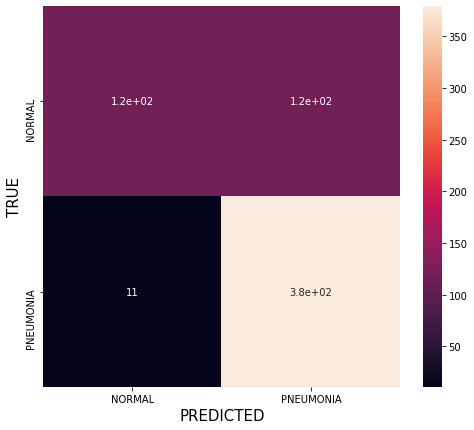

In [ ]:
plt.figure(figsize=(8,7))
xticks = np.array(['NORMAL','PNEUMONIA'])
sns.heatmap(cm, annot = True, 
            xticklabels = xticks, yticklabels = xticks)
plt.xlabel('PREDICTED',fontsize = 15)
plt.ylabel('TRUE',fontsize = 15)


# Visualising predicted results 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


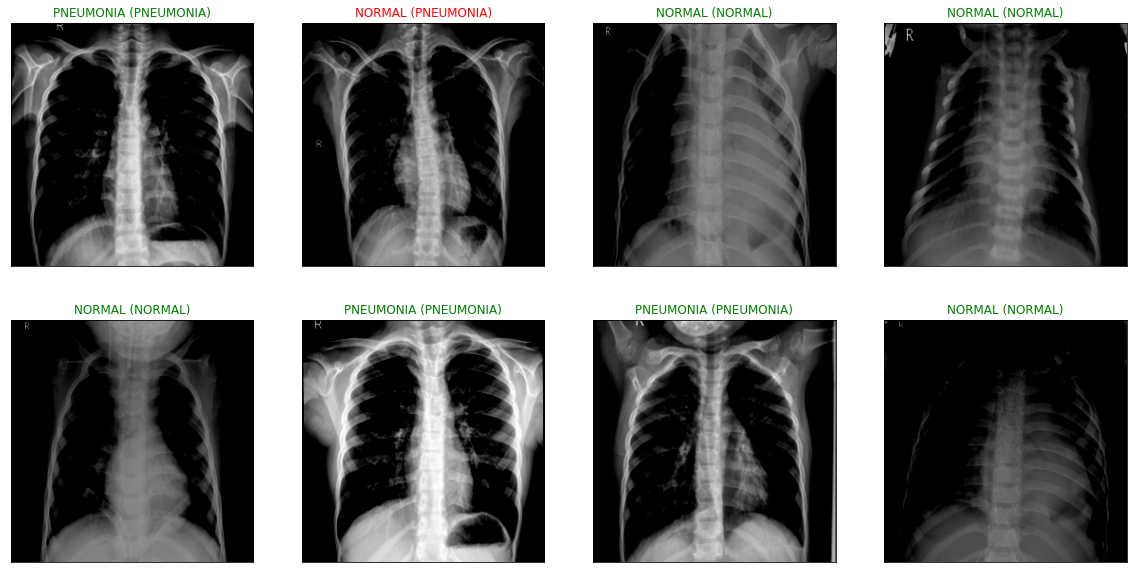

In [ ]:
# obtaining one batch of test images
data, target = next(iter(test_loader))
data.numpy()

# moving model inputs to cuda, if GPU available
if train_on_gpu:
    data = data.cuda()

# getting sample outputs
output = model(data)

# converting output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
target = tuple([0 if i=='NORMAL' else 1 for i in list(target)])

# plotting the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(20,10))
for idx in np.arange(8):
    ax = fig.add_subplot(2,4, idx+1, xticks=[], yticks=[])
    ax.imshow(data[idx].permute(1, 2, 0) if not train_on_gpu else data[idx].cpu().permute(1, 2, 0))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[target[idx]]),
                 color=("green" if preds[idx]==target[idx] else "red"))

# Using Transfer Learning

##ResNet50 backbone

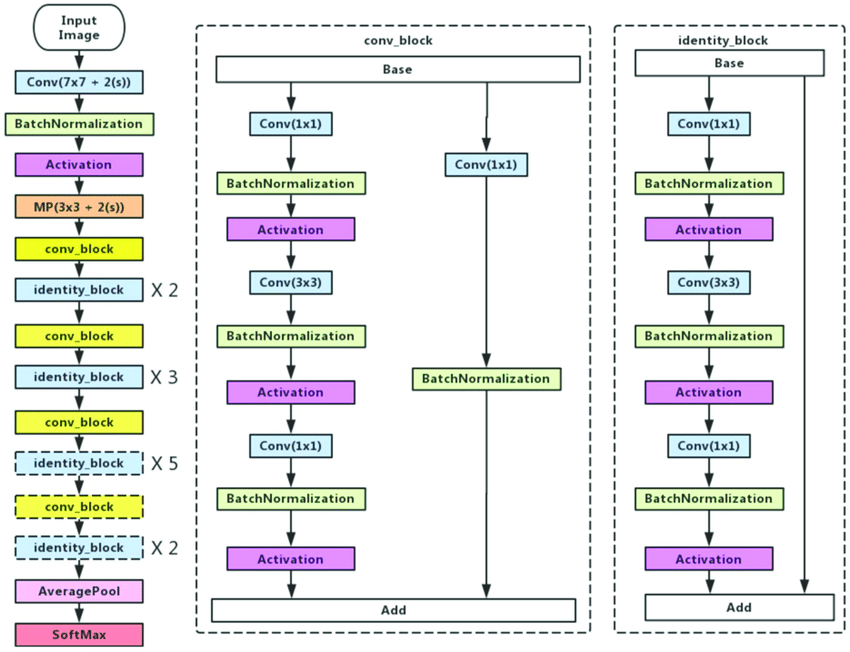

## Defining transformations according to ResNet50 standards

In [28]:
train_transforms_res = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize((224,224)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
                                       ]) 

test_transforms_res = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
                                      ])

In [29]:
train_data_res = datasets.ImageFolder(train_dir, transform = train_transforms_res)
test_data_res = datasets.ImageFolder(test_dir, transform = test_transforms_res)

# Splitting training data into training and validation sets

In [30]:
# training indices to be used for validation

num_train_res = len(train_data_res); print(num_train_res)
indices = list(range(num_train_res))
np.random.shuffle(indices)
split = int(np.floor(0.2 * num_train_res)); print(split)
train_idx, valid_idx = indices[split:], indices[:split] 

5232
1046


In [ ]:
# defining samplers for obtaining training and validation batches

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [ ]:
# loading the data 

train_loader = torch.utils.data.DataLoader(train_data_res, batch_size = 30, sampler = train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data_res, batch_size = 30, sampler = valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data_res, batch_size = 30, shuffle = True)
next(iter(test_loader))

[tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
          [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
           [-

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


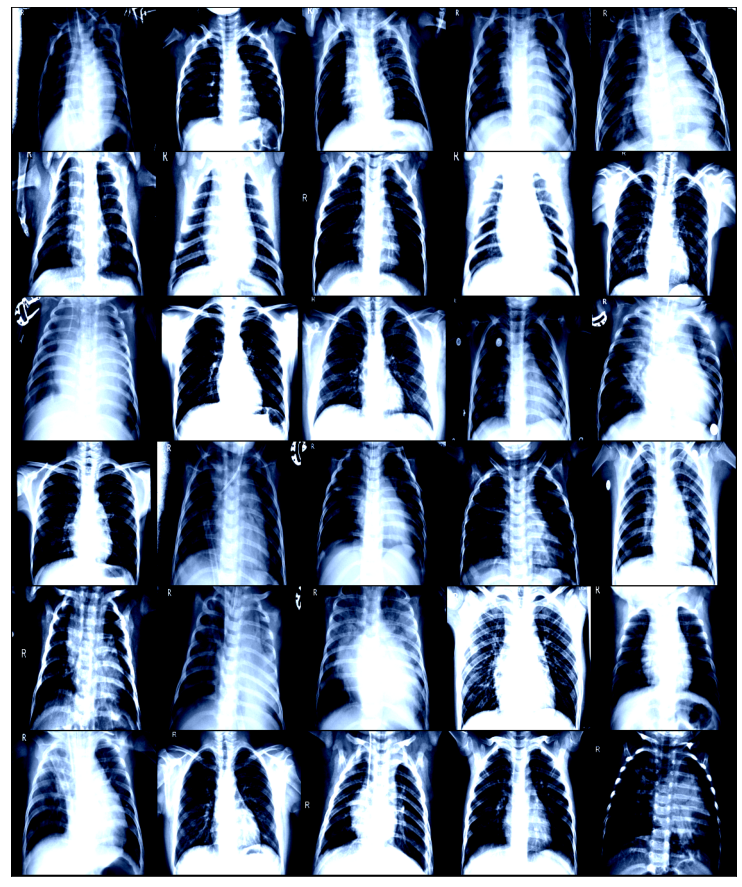

In [ ]:
show_images(test_loader)

# Loading pretrained ResNet50 model and adding final layers

In [ ]:
res_model = models.resnet50(pretrained=True)
print(res_model)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

In [ ]:
# Freezing training for all "features" layers
for param in res_model.parameters():
    param.requires_grad = False

In [ ]:
# Adding final layers
res_model.fc = nn.Sequential(nn.Linear(2048,512),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.Dropout(0.4),
                         nn.Linear(512,2),
                         nn.LogSoftmax(dim=1)) 

In [ ]:
# specifying the loss function (categorical cross-entropy)

criterion = nn.CrossEntropyLoss()

# specifying optimizer

optimizer = optim.SGD(res_model.parameters(), lr = 0.008,momentum = 0.9, nesterov = True)

# specifying scheduler

scheduler = optim.lr_scheduler.ExponentialLR(optimizer,gamma = 0.2)

if train_on_gpu:
    res_model.cuda()

print(res_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 


# Training and validating the model


In [ ]:
# number of epochs to train the model
n_epochs = 20

valid_loss_min = np.Inf # track change in validation loss
train_losses, valid_losses = [], []
train_acc, valid_acc = [], []
for epoch in range(1, n_epochs+1):

    # keeping track of loss and accuracy
    train_loss = 0.0
    valid_loss = 0.0
    train_accuracy = 0.0
    valid_accuracy = 0.0

    ######################
    # training the model #
    ######################
    res_model.train()
    for data, target in train_loader:
        # moving tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clearing the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: computing predicted outputs by passing inputs to the model
        output = res_model(data)
        target = target.long()
        # calculating the batch loss
        loss = criterion(output, target)
        # backward pass: computing gradient of the loss with respect to model parameters
        loss.backward()
        # performing a single optimization step (parameter update)
        optimizer.step()
        # updating training loss
        train_loss += loss.item()*data.size(0)
        # updating training accuracy
        train_accuracy += accuracy(output,target)
        
    scheduler.step() # decay LR

    ########################  
    # validating the model #
    ########################
    res_model.eval()
    for data, target in valid_loader:
        # moving tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: computing predicted outputs by passing inputs to the model
        output = res_model(data)
        target = target.long()
        # calculating the batch loss
        loss = criterion(output, target)
        # updating average validation loss 
        valid_loss += loss.item()*data.size(0)
        # updating validation accuracy
        valid_accuracy += accuracy(output,target)
    
    # calculating average losses
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)

    # calculating average accuracy
    train_accuracy = train_accuracy/len(train_loader)
    valid_accuracy = valid_accuracy/len(valid_loader)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_acc.append(train_accuracy)
    valid_acc.append(valid_accuracy)
      
    # printing training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \n\t\tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        epoch, train_loss, valid_loss, train_accuracy, valid_accuracy))
    
    # saving model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(res_model.state_dict(), '/content/res_model_pneumonia.pt')
        valid_loss_min = valid_loss

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1 	Training Loss: 6.155660 	Validation Loss: 3.371791 
		Training Accuracy: 0.914822 	Validation Accuracy: 0.957949
Validation loss decreased (inf --> 3.371791).  Saving model ...
Epoch: 2 	Training Loss: 3.940007 	Validation Loss: 3.083077 
		Training Accuracy: 0.951191 	Validation Accuracy: 0.958755
Validation loss decreased (3.371791 --> 3.083077).  Saving model ...
Epoch: 3 	Training Loss: 3.591095 	Validation Loss: 2.773029 
		Training Accuracy: 0.952739 	Validation Accuracy: 0.962564
Validation loss decreased (3.083077 --> 2.773029).  Saving model ...
Epoch: 4 	Training Loss: 3.427958 	Validation Loss: 2.892617 
		Training Accuracy: 0.953334 	Validation Accuracy: 0.960659
Epoch: 5 	Training Loss: 3.563655 	Validation Loss: 3.107009 
		Training Accuracy: 0.955030 	Validation Accuracy: 0.962857
Epoch: 6 	Training Loss: 3.799106 	Validation Loss: 2.364891 
		Training Accuracy: 0.954048 	Validation Accuracy: 0.970330
Validation loss decreased (2.773029 --> 2.364891).  Saving m

# Plotting training/validation losses

(array([2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5]),
 <a list of 10 Text major ticklabel objects>)

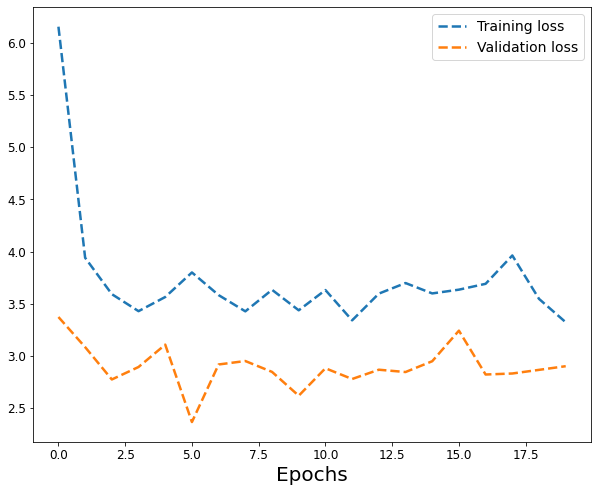

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(train_losses,'--',linewidth = 2.5, label='Training loss')
plt.plot(valid_losses,'--', linewidth = 2.5, label='Validation loss')
plt.xlabel('Epochs',fontsize = 20)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12);

# Plotting training/validation accuracy

(array([0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98]),
 <a list of 8 Text major ticklabel objects>)

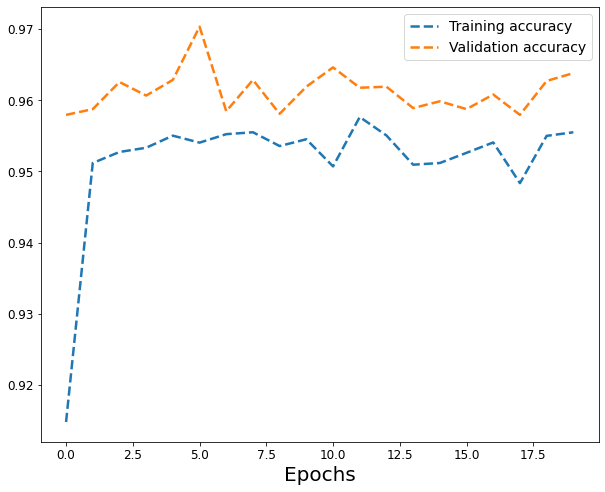

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(train_acc,'--', linewidth = 2.5, label='Training accuracy')
plt.plot(valid_acc,'--', linewidth = 2.5, label='Validation accuracy')
plt.xlabel('Epochs', fontsize = 20)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12);

# Loading model with lowest validation loss

In [ ]:
res_model.load_state_dict(torch.load('res_model_pneumonia.pt'))


<All keys matched successfully>

# Testing the model

In [ ]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

res_model.eval()
# iterating over test data
for data, target in test_loader:
    # moving tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: computing predicted outputs by passing inputs to the model
    output = res_model(data)
    target = target.long()
    # calculating the batch loss
    loss = criterion(output, target)
    # updating test loss 
    test_loss += loss.item()*data.size(0)
    # converting output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # comparing predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculating test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.417607

Test Accuracy of NORMAL: 69% (163/234)
Test Accuracy of PNEUMONIA: 96% (377/390)

Test Accuracy (Overall): 86% (540/624)


# Evaulating the model

In [ ]:
confusion_matrix = torch.zeros(2,2)
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        if train_on_gpu:
        data, target = data.cuda(), target.cuda()
        output = res_model(data)
        target = target.long()
        _, preds = torch.max(output, 1)
    for t, p in zip(target.view(-1), preds.view(-1)):
        confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[163.,  71.],
        [ 13., 377.]])


In [ ]:
cm = confusion_matrix.numpy()
tn, fp, fn, tp = cm.ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1_score = (2*precision*recall)/(precision+recall)
print("Precision: {:.4f}\nRecall: {:.4f}\nF1 Score: {:.4f}".format(precision,recall,f1_score))

Precision: 0.8415
Recall: 0.9667
F1 Score: 0.8998


Text(51.0, 0.5, 'TRUE')

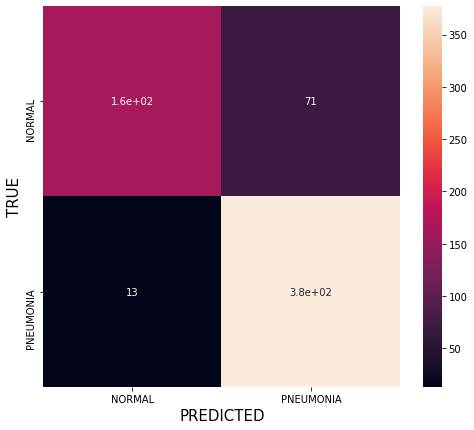

In [ ]:
plt.figure(figsize=(8,7))
xticks = np.array(['NORMAL','PNEUMONIA'])
sns.heatmap(cm, annot = True, xticklabels = xticks, yticklabels = xticks)
plt.xlabel('PREDICTED',fontsize = 15)
plt.ylabel('TRUE',fontsize = 15)

# Visualising predicted results 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


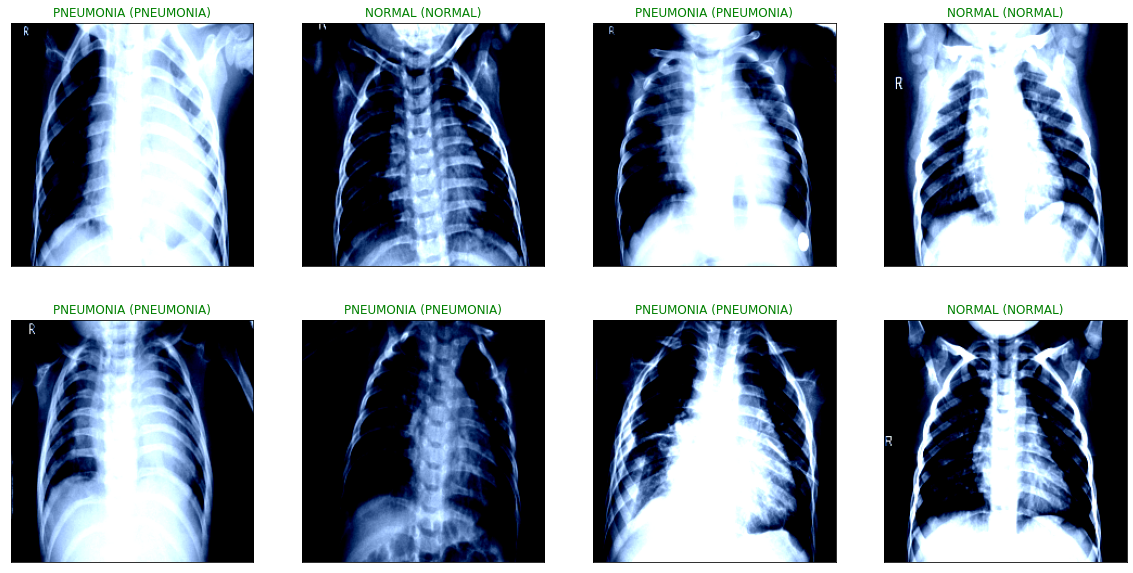

In [ ]:
# obtaining one batch of test images
data, target = next(iter(test_loader))
data.numpy()

# moving model inputs to cuda, if GPU available
if train_on_gpu:
    data = data.cuda()

# getting sample outputs
output = res_model(data)

# converting output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plotting the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(20,10))
for idx in np.arange(8):
    ax = fig.add_subplot(2,4, idx+1, xticks=[], yticks=[])
    ax.imshow(data[idx].permute(1, 2, 0) if not train_on_gpu else data[idx].cpu().permute(1, 2, 0))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[target[idx]]),
                 color=("green" if preds[idx]==target[idx] else "red"))

# Visual Saliency

We have trained and validated our models, tested them on new images and they seem to give pretty good results ! But we still lack something : **model interpratability**. Where exactly is the model looking at, to make its final decision ? Does some particular portion of the image influence the model's decision more than other portions ? These questions are tackled by 'visual saliency', which demystifies the black box that is a neural network.
Visual saliency is a visualisation technique, where we plot the saliency maps of an image, which are basically heatmaps, where the 'hotness' corresponds to regions that have a big impact on the model's final decision.
Saliency maps are created by backpropagating on the raw scores, instead of the model losses, hence I am using a pretrained VGG-16 model to train my network.

In [ ]:
vgg16 = models.vgg16(pretrained=True)
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [ ]:
# Freezing training for all "features" layers
for param in vgg16.features.parameters():
    param.requires_grad = False

In [ ]:
# Adding final layers
vgg16.fc = nn.Sequential(nn.Linear(4096,512),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.Dropout(0.5),
                         nn.Linear(512,2),
                         nn.LogSoftmax(dim=1)) 

In [ ]:
# specifying the loss function (categorical cross-entropy)

criterion = nn.CrossEntropyLoss()

# specifying optimizer

optimizer = optim.SGD(vgg16.parameters(), lr = 0.008,momentum = 0.9, nesterov = True)

# specifying scheduler

scheduler = optim.lr_scheduler.ExponentialLR(optimizer,gamma = 0.2)

if train_on_gpu:
    vgg16.cuda()

print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1


# Training and validating the model


In [ ]:
# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss
train_losses, valid_losses = [], []
train_acc, valid_acc = [], []
for epoch in range(1, n_epochs+1):

    # keeping track of loss and accuracy
    train_loss = 0.0
    valid_loss = 0.0
    train_accuracy = 0.0
    valid_accuracy = 0.0

    ######################
    # training the model #
    ######################
    vgg16.train()
    for data, target in train_loader:
        # moving tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clearing the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: computing predicted outputs by passing inputs to the model
        output = vgg16(data)
        target = target.long()
        # calculating the batch loss
        loss = criterion(output, target)
        # backward pass: computing gradient of the loss with respect to model parameters
        loss.backward()
        # performing a single optimization step (parameter update)
        optimizer.step()
        # updating training loss
        train_loss += loss.item()*data.size(0)
        # updating training accuracy
        train_accuracy += accuracy(output,target)
        
    scheduler.step() # decay LR

    ########################  
    # validating the model #
    ########################
    vgg16.eval()
    for data, target in valid_loader:
        # moving tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: computing predicted outputs by passing inputs to the model
        output = vgg16(data)
        target = target.long()
        # calculating the batch loss
        loss = criterion(output, target)
        # updating average validation loss 
        valid_loss += loss.item()*data.size(0)
        # updating validation accuracy
        valid_accuracy += accuracy(output,target)
    
    # calculating average losses
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)

    # calculating average accuracy
    train_accuracy = train_accuracy/len(train_loader)
    valid_accuracy = valid_accuracy/len(valid_loader)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_acc.append(train_accuracy)
    valid_acc.append(valid_accuracy)
      
    # printing training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \n\t\tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        epoch, train_loss, valid_loss, train_accuracy, valid_accuracy))
    
    # saving model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(vgg16.state_dict(), '/content/vgg16_pneumonia.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 15.554604 	Validation Loss: 3.973079 
		Training Accuracy: 0.875239 	Validation Accuracy: 0.952381
Validation loss decreased (inf --> 3.973079).  Saving model ...
Epoch: 2 	Training Loss: 3.901297 	Validation Loss: 2.150535 
		Training Accuracy: 0.951667 	Validation Accuracy: 0.974286
Validation loss decreased (3.973079 --> 2.150535).  Saving model ...
Epoch: 3 	Training Loss: 3.381747 	Validation Loss: 2.478588 
		Training Accuracy: 0.959524 	Validation Accuracy: 0.971429
Epoch: 4 	Training Loss: 3.101042 	Validation Loss: 2.490750 
		Training Accuracy: 0.959346 	Validation Accuracy: 0.969524
Epoch: 5 	Training Loss: 3.032762 	Validation Loss: 2.348050 
		Training Accuracy: 0.960715 	Validation Accuracy: 0.971282
Epoch: 6 	Training Loss: 3.149458 	Validation Loss: 2.335027 
		Training Accuracy: 0.963095 	Validation Accuracy: 0.974286
Epoch: 7 	Training Loss: 3.286646 	Validation Loss: 2.677234 
		Training Accuracy: 0.963095 	Validation Accuracy: 0.966520
Epoch

# Plotting training/validation losses

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(train_losses,'--',linewidth = 2.5, label='Training loss')
plt.plot(valid_losses,'--', linewidth = 2.5, label='Validation loss')
plt.xlabel('Epochs',fontsize = 20)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12);

# Plotting training/validation accuracy

(array([0.86, 0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <a list of 8 Text major ticklabel objects>)

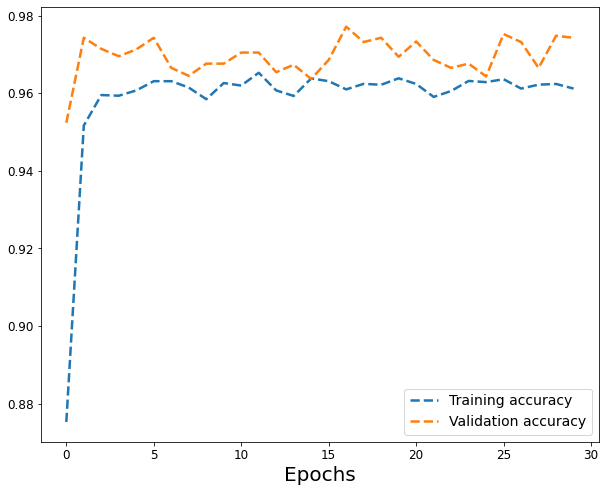

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(train_acc,'--', linewidth = 2.5, label='Training accuracy')
plt.plot(valid_acc,'--', linewidth = 2.5, label='Validation accuracy')
plt.xlabel('Epochs', fontsize = 20)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12);

# Loading model with lowest validation loss

In [ ]:
vgg16.load_state_dict(torch.load('vgg16_pneumonia.pt'))

<All keys matched successfully>

# Testing the model

In [ ]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

vgg16.eval()
# iterating over test data
for data, target in test_loader:
    # moving tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: computing predicted outputs by passing inputs to the model
    output = vgg16(data)
    target = target.long()
    # calculating the batch loss
    loss = criterion(output, target)
    # updating test loss 
    test_loss += loss.item()*data.size(0)
    # converting output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # comparing predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculating test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.421266

Test Accuracy of NORMAL: 66% (156/234)
Test Accuracy of PNEUMONIA: 97% (382/390)

Test Accuracy (Overall): 86% (538/624)


# Evaulating the model

In [ ]:
confusion_matrix = torch.zeros(2,2)
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
            output = vgg16(data)
            target = target.long()
            _, preds = torch.max(output, 1)
        for t, p in zip(target.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[156.,  78.],
        [  8., 382.]])


In [ ]:
cm = confusion_matrix.numpy()
tn, fp, fn, tp = cm.ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1_score = (2*precision*recall)/(precision+recall)
print("Precision: {:.4f}\nRecall: {:.4f}\nF1 Score: {:.4f}".format(precision,recall,f1_score))

Precision: 0.8304
Recall: 0.9795
F1 Score: 0.8988


Text(51.0, 0.5, 'TRUE')

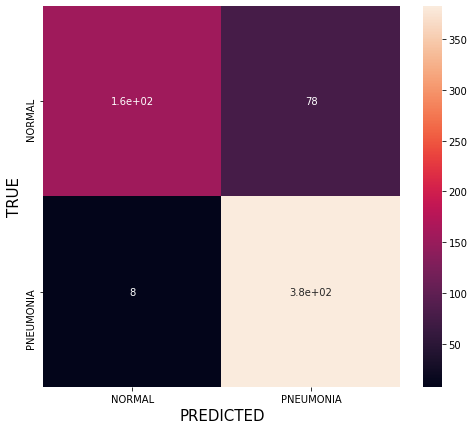

In [ ]:
plt.figure(figsize=(8,7))
xticks = np.array(['NORMAL','PNEUMONIA'])
sns.heatmap(cm, annot = True, 
            xticklabels = xticks, yticklabels = xticks)
plt.xlabel('PREDICTED',fontsize = 15)
plt.ylabel('TRUE',fontsize = 15)


# Visualising predicted results 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


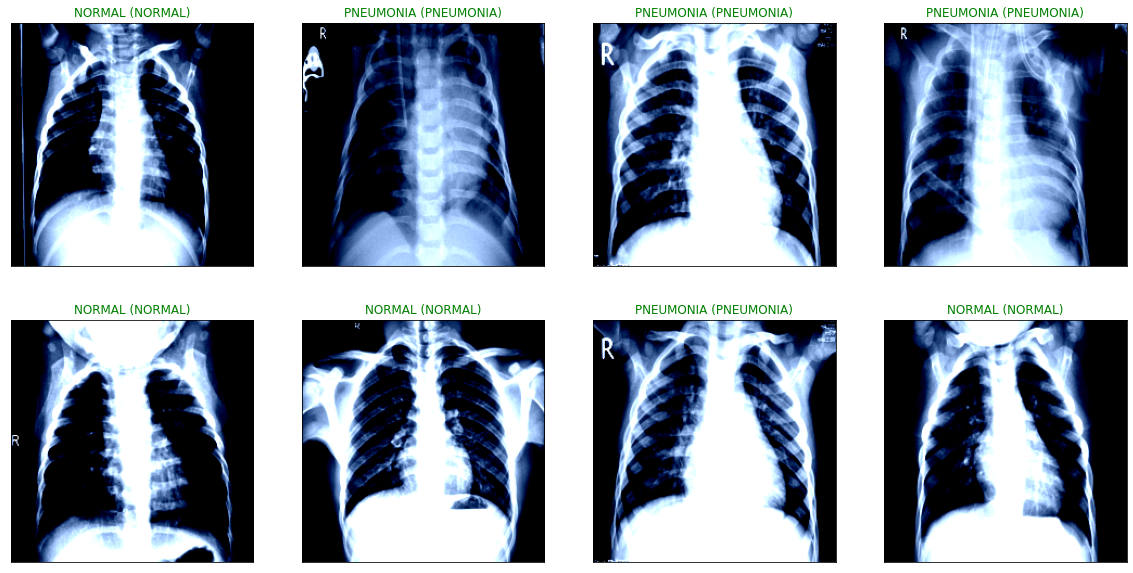

In [ ]:
# obtaining one batch of test images
data, target = next(iter(test_loader))
data.numpy()

# moving model inputs to cuda, if GPU available
if train_on_gpu:
    data = data.cuda()

# getting sample outputs
output = vgg16(data)

# converting output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plotting the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(20,10))
for idx in np.arange(8):
    ax = fig.add_subplot(2,4, idx+1, xticks=[], yticks=[])
    ax.imshow(data[idx].permute(1, 2, 0) if not train_on_gpu else data[idx].cpu().permute(1, 2, 0))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[target[idx]]),
                 color=("green" if preds[idx]==target[idx] else "red"))

# Plotting Saliency Maps

In [ ]:
# intialising the model

vgg16.load_state_dict(torch.load('vgg16_pneumonia.pt'))

device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")

vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# opening the image file

#image = Image.open('/content/chest_xray/train/NORMAL/IM-0131-0001.jpeg').convert('RGB')
image = Image.open('/content/chest_xray/train/NORMAL/IM-0487-0001.jpeg').convert('RGB')

# setting up transforms

vs_transform = transforms.Compose([transforms.Resize((224,224)),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                   ])

# transforming the image

image = vs_transform(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


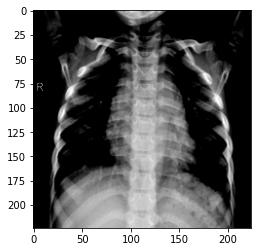

In [ ]:
plt.imshow(image.permute(1,2,0))

In [ ]:
image = image.reshape(1,3,224,224)
image.shape

torch.Size([1, 3, 224, 224])

In [ ]:
# backpropagating on the class scores

image = image.to(device)
image.requires_grad = True
vsout = vgg16(image)
vsout_idx = vsout.argmax()
vsout_max = vsout[0,vsout_idx]
vsout_max.backward()

In [ ]:
saliency,_ = torch.max(image.grad.data.abs(), dim=1)
saliency = saliency.reshape(224,224)
image = image.reshape(-1,224,224)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Saliency Map')

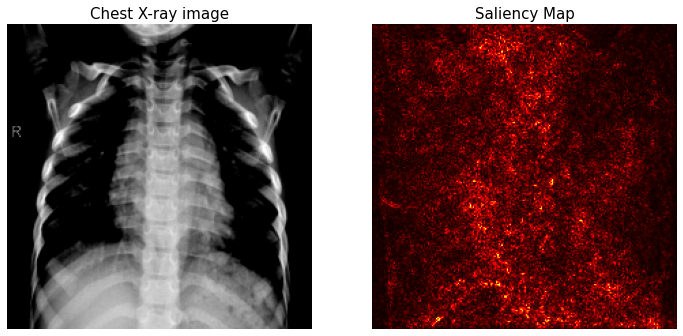

In [ ]:
fig = plt.figure(figsize=(12,12))

plt.subplot(121)
plt.imshow(image.cpu().detach().numpy().transpose(1, 2, 0))
plt.axis('off')
plt.title('Chest X-ray image',fontdict = {'fontsize' : 15})

plt.subplot(122)
plt.imshow(saliency.cpu(), cmap='hot')
plt.axis('off')
plt.title('Saliency Map',fontdict = {'fontsize' : 15})